# Hopkins Test 

## Code

In [ ]:
import numpy as np
from numpy.random import random
from sklearn.datasets import make_blobs
from scipy.spatial import KDTree
from scipy.stats import poisson
from sklearn.neighbors import NearestNeighbors
import itertools


np.random.seed(42)


def hopkins_statistic(X, N):
    
    #n = len(X)  # number of samples
    m = int(0.1 * N)  # use 10% of points as random points
    random_points = np.random.uniform(X.min(), X.max(), size=(N, X.shape[1]))
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    _, distances_random_point = nbrs.kneighbors(random_points, n_neighbors=1)

    random_indices = np.random.choice(N, size=m, replace=False)
    random_real_points = X[random_indices]

    _, distances_real_point = nbrs.kneighbors(random_real_points, n_neighbors=2)
    
    distances_real_point = distances_real_point[:, 1]
    H = np.sum(distances_real_point) / (np.sum(distances_random_point) + np.sum(distances_real_point))
    
    return H


def hopkins_skellen_2d(X, area_width, area_height, N):
    tree = KDTree(X)
    distances, indices = tree.query(X, k=2)
    s_dist_squared = sum([x**2 for x in distances[:,1]])

    random_points = [(area_width*random(), area_height*random()) for _ in range(N)]
    X_rnd = np.array(random_points)

    distances, indices = tree.query(X_rnd, k=1)
    r_dist_squared = sum([x**2 for x in distances])
    H = r_dist_squared/s_dist_squared
    return H


def hopkins_skellen_nd(X, N):
    tree = KDTree(X)

    # Calculate the nearest neighbor distances on actual data
    distances, indices = tree.query(X, k=2)
    s_dist_squared = sum([x**2 for x in distances[:,1]])

    # Generate random points
    random_points = np.random.uniform(X.min(), X.max(), size=(N, X.shape[1]))
    X_rnd = np.array(random_points)
    distances, indices = tree.query(X_rnd, k=1)
    r_dist_squared = sum([x**2 for x in distances])

    H = r_dist_squared/s_dist_squared
    return H


def simulate_hopkins_distribution(original_data, N, iterations=1000):
    empirical_H_values = []
    for _ in range(iterations):
        # Generate random dataset
        random_data = np.random.uniform(low=original_data.min(), high=original_data.max(), size=original_data.shape)
        # Calculate H for random dataset
        #H = hopkins_statistic(random_data, N)
        H = hopkins_skellen_nd(random_data, N)
        empirical_H_values.append(H)
    return np.array(empirical_H_values)


def create_spatially_smooth_data(num_rows, num_dims, repeat):
    """
    Create a list of lists where each inner list represents a point in a num_dims-dimensional space.
    Each dimension value ranges from 0 to num_rows-1, incremented by 'repeat'.

    Parameters:
    - num_dims: int, number of dimensions
    - num_rows: int, maximum size of each dimension
    - repeat: int, increment between each value in each dimension

    Returns:
    - list of lists: each sub-list represents a coordinate in the multidimensional space
    """
    # Generate a range for each dimension
    range_list = [range(0, num_rows, repeat) for _ in range(num_dims)]
    
    # Use itertools.product to generate all combinations of the ranges
    all_combinations = list(itertools.product(*range_list))
    
    return np.array(all_combinations)


def create_clustered_data(num_rows=20, num_dims=2, num_clusters=5, cluster_std=1):

    # Generate isotropic Gaussian blobs
    X, y = make_blobs(
        n_samples=num_rows, 
        n_features=num_dims, 
        centers=num_clusters, 
        cluster_std=cluster_std, 
        random_state=42
    )
    
    return X, y

def calculate_n(dimensions, density=0.1):
    """
    Calculate the number of points for an n-dimensional Poisson process.

    Parameters:
    - dimensions: list or tuple of int, the sizes of each dimension (e.g., [width, height, depth])
    - density: float, the density of points per unit volume.

    Returns:
    - int: number of points (N) to generate based on the Poisson distribution.
    """
    # Calculate the volume of the n-dimensional space
    V = np.prod(dimensions)  # Product of elements in dimensions list

    # Calculate the Poisson parameter (λ = Volume * Density)
    poisson_parameter = V * density

    # Generate a random number and calculate N
    u = random()
    N = int(poisson.ppf(u, poisson_parameter))

    return N


Smooth data

In [ ]:
shape = [100, 5]
repeat = 20
area_width = shape[0]
area_height = shape[0]

N = calculate_n(shape)
print("Number of points (N):", N)

# create smooth data
smooth_data = create_spatially_smooth_data(shape[0], shape[1], repeat=repeat)
print("smooth data shape: ", smooth_data.shape)

if shape[1] == 2:
    h2d = hopkins_skellen_2d(smooth_data, area_width, area_height, N)
    print("Hopkins-skellen statistic (2D):", h2d)
hnd = hopkins_skellen_nd(smooth_data, N)
print("Hopkins-skellen statistic ({}D):".format(shape[1]), hnd)

smooth_H = hopkins_statistic(smooth_data, N)
print(f"H-statistic: {smooth_H}")


Number of points (N): 48
smooth data shape:  (3125, 5)
Hopkins-skellen statistic (5D): 0.006448481927225633
H-statistic: 0.00152795571279134


Clustered data

In [ ]:
clustered_data, y = create_clustered_data(num_rows=shape[0], num_dims=shape[1], num_clusters=5, cluster_std=1)

if shape[1] == 2:
    h2d = hopkins_skellen_2d(clustered_data, area_width, area_height, N)
    print("Hopkins-skellen statistic (2D):", h2d)
hnd = hopkins_skellen_nd(clustered_data, N)
print("Hopkins-skellen statistic ({}D):".format(shape[1]), hnd)

smooth_H = hopkins_statistic(clustered_data, N)
print(f"H-statistic: {smooth_H}")


Hopkins-skellen statistic (5D): 30.007109244179446
H-statistic: 0.050213675213675216


## Compare the Hopkins statistic for smooth and clustered data

In [ ]:
#original_data = clustered_data  
original_data = smooth_data

In [ ]:

# Assuming `original_data` is your dataset
#original_data = np.random.rand(100, 4)  # Example: 100 points in 2D
original_H = hopkins_skellen_nd(original_data, N)
empirical_distribution = simulate_hopkins_distribution(original_data, N, iterations=1000)

# Analyze the result
print(f"Original H: {original_H}")
print(f"Mean of simulated H values: {np.mean(empirical_distribution)}")
# You can also plot the distribution or calculate percentiles to analyze further

Original H: 0.006046984150226116
Mean of simulated H values: 0.015347748029290741


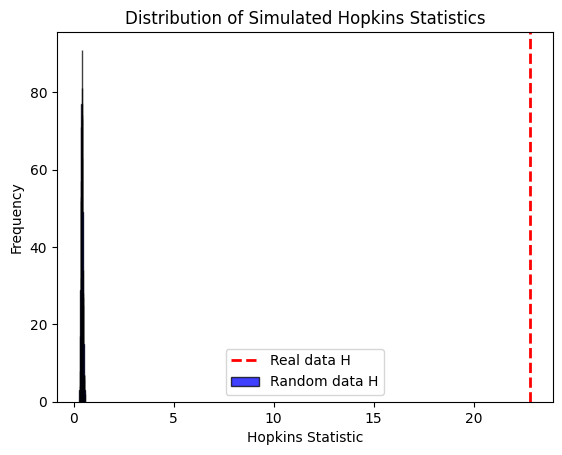

5th Percentile: 0.34379982469383286
25th Percentile: 0.3821376975878886
50th Percentile: 0.41176349745783963
75th Percentile: 0.44126901098463667
95th Percentile: 0.4903146239729324
Original dataset's H percentile rank: 100.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `empirical_distribution` contains your simulated Hopkins statistics
# and `original_H` is the Hopkins statistic for your original dataset

# Plot the distribution of the simulated Hopkins statistics
plt.hist(empirical_distribution, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(original_H, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Simulated Hopkins Statistics')
plt.xlabel('Hopkins Statistic')
plt.ylabel('Frequency')
plt.legend(['Real data H', 'Random data H'])
plt.show()

# Calculate and print percentiles
percentiles = [5, 25, 50, 75, 95]
for p in percentiles:
    value = np.percentile(empirical_distribution, p)
    print(f"{p}th Percentile: {value}")

# Assess where the original dataset's H stands
percentile_rank = (np.sum(empirical_distribution < original_H) / len(empirical_distribution)) * 100
print(f"Original dataset's H percentile rank: {percentile_rank}")


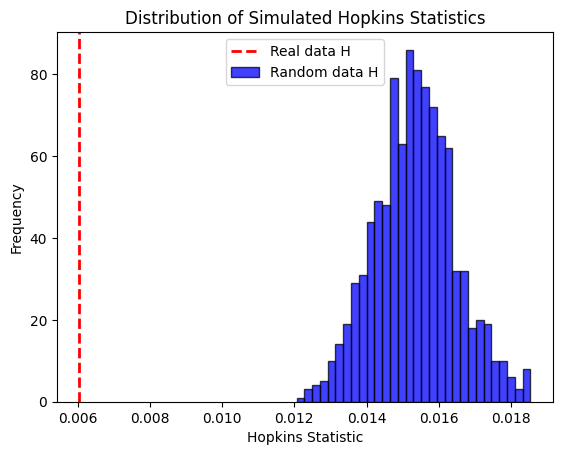

5th Percentile: 0.013538661095305
25th Percentile: 0.014614558272209052
50th Percentile: 0.015347045089573075
75th Percentile: 0.016071977970928734
95th Percentile: 0.017321997780348337
Original dataset's H percentile rank: 0.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `empirical_distribution` contains your simulated Hopkins statistics
# and `original_H` is the Hopkins statistic for your original dataset

# Plot the distribution of the simulated Hopkins statistics
plt.hist(empirical_distribution, bins=30, alpha=0.75, color='blue', edgecolor='black')
plt.axvline(original_H, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Simulated Hopkins Statistics')
plt.xlabel('Hopkins Statistic')
plt.ylabel('Frequency')
plt.legend(['Real data H', 'Random data H'])
plt.show()

# Calculate and print percentiles
percentiles = [5, 25, 50, 75, 95]
for p in percentiles:
    value = np.percentile(empirical_distribution, p)
    print(f"{p}th Percentile: {value}")

# Assess where the original dataset's H stands
percentile_rank = (np.sum(empirical_distribution < original_H) / len(empirical_distribution)) * 100
print(f"Original dataset's H percentile rank: {percentile_rank}")
